**1.1 Import Dependencies**

In [1]:
import tensorflow as tf


In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

**1.2 Set GPU Growth**

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

**1.3 Create Folder Structures**

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

**2 Collect Positive and Anchor Classes**

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    #frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
from PIL import Image
for image in os.listdir(os.path.join('data','positive')):
    if image.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
     with Image.open(os.path.join('data','positive', image)) as img:
        left, top, right, bottom = 554, 145, 804, 395
        
        img_cropped = img.crop((left, top, right, bottom))
        
        # Save the cropped image to the output directory
        output_filename = os.path.join('Saved','{}.jpg'.format(uuid.uuid1()))
        img_cropped.save(output_filename)

**2.x NEW - Data Augmentation**

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [ ]:
img_path = os.path.join(ANC_PATH, '6e9a6708-768f-11ee-ad81-16b96afca145.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

**3. Load and Preprocess Images**

**3.1 Get Image Directories**

In [11]:
anchor = tf.data.Dataset.list_files('data/anchor/*.jpg').take(500)
positive = tf.data.Dataset.list_files('data/positive/*.jpg').take(500)
negative = tf.data.Dataset.list_files('data/negative/*.jpg').take(500)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'data/anchor/6f8b132e-768f-11ee-ad81-16b96afca145.jpg'


**3.2 Preprocessing - Scale and Resize**

In [22]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

**3.3 Create Labelled Dataset**

In [23]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
samples = data.as_numpy_iterator()

In [26]:
exampple = samples.next()

In [27]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [28]:
res = preprocess_twin(*exampple)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


In [29]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [30]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [31]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

**4. Model Engineering**

**4.1 Build Embedding Layer**

In [32]:
inp = Input(shape=(100,100,3), name='input_image')


In [33]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [34]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [35]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [36]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)


In [37]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)


In [38]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')


In [39]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [40]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [50]:
model = make_embedding()

model.summary()

**4.2 Build Distance Layer**

In [52]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [53]:
l1 = L1Dist()

**4.3 Make Siamese Model**

In [56]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [57]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [58]:
siamese_layer = L1Dist()

In [59]:
distances = siamese_layer(inp_embedding, val_embedding)

In [60]:
classifier = Dense(1, activation='sigmoid')(distances)

In [61]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [62]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [63]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [64]:
siamese_model = make_siamese_model()

In [65]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

**5. Training**

**5.1 Setup Loss and Optimizer**

In [66]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [67]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

**5.2 Establish Checkpoints**

In [68]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

**5.3 Build Train Step Function**

In [69]:
test_batch = train_data.as_numpy_iterator()

In [72]:
batch_1 = test_batch.next()

In [73]:
X = batch_1[:2]

In [74]:
y = batch_1[2]

In [75]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
        loss=tf.ke

In [76]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

**5.4 Build Training Loop**

In [80]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [81]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

**5.5 Train the model**

In [82]:
EPOCHS = 50

In [83]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 372s 8s/step
0.023431137 0.76584023 1.0

 Epoch 2/50
44/44 [==============================] - 371s 8s/step
0.16984588 0.99717516 1.0

 Epoch 3/50
44/44 [==============================] - 578s 13s/step
0.002666925 0.99157304 0.99717516

 Epoch 4/50
44/44 [==============================] - 355s 8s/step
0.07172222 0.994302 0.98866856

 Epoch 5/50
44/44 [==============================] - 359s 8s/step
0.09543449 0.9751381 1.0

 Epoch 6/50
44/44 [==============================] - 361s 8s/step
3.4041102e-05 0.9942857 1.0

 Epoch 7/50
44/44 [==============================] - 360s 8s/step
0.0004894873 0.9852507 1.0

 Epoch 8/50
44/44 [==============================] - 419s 10s/step
0.012049685 0.997151 1.0

 Epoch 9/50
44/44 [==============================] - 226s 5s/step
3.4769382e-08 0.99

**6. Evaluate Model**

**6.1 Import Metrics**

In [84]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

**6.2 Make Predictions**

In [85]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [86]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 783ms/step


In [87]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1]

In [88]:
y_true

array([1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

**6.3 Calculate Metrics**

In [89]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [90]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [91]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 652ms/step
1.0 1.0


**6.4 Viz Results**

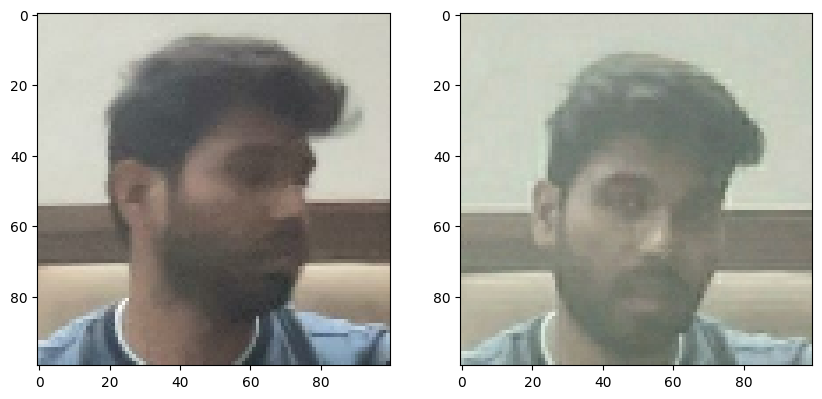

In [108]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[4])

# Renders cleanly
plt.show()

**7. Save Model**

In [109]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

/Users/purushottamsahu/myenv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [110]:
L1Dist

__main__.L1Dist

In [111]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [112]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


array([[6.82286909e-12],
       [1.00000000e+00],
       [9.99649644e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [4.12658085e-09],
       [9.99546409e-01],
       [8.14112042e-11],
       [1.00000000e+00],
       [9.99544263e-01],
       [1.03945345e-10]], dtype=float32)

In [113]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     